# Dog Breed Classification

This is a Machine Learning Model to classify between 133 kinds of dog breeds usaing dog breed dataset by Udacity (https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip)

Using the pretrained Resnet34 model from pytorch vision (https://pytorch.org/vision/master/generated/torchvision.models.resnet34.html), build two later neural networks to classify between the breeds of dogs based on the provided image.


In [2]:
# installing packages
!pip install smdebug
!pip install torch --no-cache-dir

In [4]:
# importing packages
import sagemaker
import boto3
import os
from sagemaker.pytorch import PyTorch
import torch

## Dataset

We are using the Dog breed dataset provided by Udacity. This is a dataset with 133 different classes of dogs around the world, we will use the images in the datasets to train our model to classify between different breeds of Dogs.

In [5]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = "us-east-1"

In [6]:
# Command to download and unzip data
#!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00058.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00071.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00078.jpg  
   creating: dogImages/test/002.Afghan_hound/
  inflating: dogImages/test/002.Afghan_hound/Afghan_hound_00116.jpg  
  inflating: dogImages/test/002.Afghan_hound/Afghan_hound_00125.jpg  
  inflating: dogImages/test/002.Afghan_hound/Afghan_ho

In [7]:
# use default S3 bucket
bucket = sagemaker_session.default_bucket()

import os
# Upload data to S3 bucket.
os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/dogImages/

upload: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg to s3://sagemaker-us-east-1-440191285067/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00078.jpg to s3://sagemaker-us-east-1-440191285067/dogImages/test/001.Affenpinscher/Affenpinscher_00078.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg to s3://sagemaker-us-east-1-440191285067/dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg to s3://sagemaker-us-east-1-440191285067/dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg to s3://sagemaker-us-east-1-440191285067/dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00071.jpg to s3://sagemaker-us-east-1-440191285067/dogImages/test/001.Affenpinscher/Affenpinscher_00071.jpg
upload: dogImages/test

**Version-2-update**

In version-2 I skip the HPO part.

## Hyperparameter Tuning
This is the part where we will finetune a pretrained model with hyperparameter tuning. We will tune *Learning Rate* and *Batchsize*.

**Note:** We will need to use the `hpo.py` script to perform hyperparameter tuning.

In [9]:
# Declare HP ranges
from sagemaker.tuner import (
    #IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256])
}
objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [10]:
# Creating estimators for Hyperparameter tuning jobs

from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name = 'hpo_tuning_dog_breed',
    role=role,
    py_version='py3',
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
    )


tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [11]:
# assigning S3 paths for the training job
s3_data = "s3://{}/{}/".format(bucket, "dogImages")
s3_output_dir = "s3://{}/{}/".format(bucket, "output")
s3_model_dir = "s3://{}/{}/".format(bucket, "model")

os.environ['SM_CHANNEL_TRAIN']= s3_data
os.environ['SM_MODEL_DIR']= s3_model_dir
os.environ['SM_OUTPUT_DATA_DIR']= s3_output_dir

In [13]:
# Fit the HP Tuner with input data channel

tuner.fit({'train' : s3_data},wait=True) 



..................................................................................................................................................................................!


In [14]:
# Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

# Getting the hyperparameters of the best trained model
best_estimator.hyperparameters()


2021-12-03 11:31:58 Starting - Preparing the instances for training
2021-12-03 11:31:58 Downloading - Downloading input data
2021-12-03 11:31:58 Training - Training image download completed. Training in progress.
2021-12-03 11:31:58 Uploading - Uploading generated training model
2021-12-03 11:31:58 Completed - Training job completed


{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'lr': '0.0013439939513439198',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"hpo_tuning_dog_breed-2021-12-03-11-25-00-512"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-440191285067/hpo_tuning_dog_breed-2021-12-03-11-25-00-512/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
Using the best hyperparameters, create and finetune a new model

**Note:** We will need to use the `train_model.py` script to perform model profiling and debugging.

In [12]:
# Setting up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, CollectionConfig
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]
collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)
debugger_config=DebuggerHookConfig(
    collection_configs=collection_configs
)

metric_definitions = [{"Name": "Train Loss", "Regex": "Train Loss: ([0-9\\.]+)"},{"Name": "Test Loss", "Regex": "Average Test Loss: ([0-9\\.]+)"}]
#debugger_config = DebuggerHookConfig(
        #hook_parameters={"train.save_interval": "10", "eval.save_interval": "10"}
#)

In [20]:
# Create and fit an estimator with best parameters

hyperparameters = {"batch_size": "32", "lr": "0.0013439939513439198"} # Training with best parameters
estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    entry_point="train_model.py",
    framework_version="1.4.0",
    py_version="py3",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config, # include the profiler hook
    debugger_hook_config=debugger_config, # include the debugger hook
    rules=rules,
    metric_definitions = metric_definitions,
)

estimator.fit({'train' : s3_data},wait=True)

INFO:sagemaker:Creating training-job with name: pytorch-training-2022-03-18-14-58-41-221


2022-03-18 14:58:41 Starting - Starting the training job...
2022-03-18 14:59:11 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
.........
2022-03-18 15:00:36 Starting - Preparing the instances for training......
2022-03-18 15:01:36 Downloading - Downloading input data............
2022-03-18 15:03:37 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-03-18 15:03:33,419 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-03-18 15:03:33,442 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-03-18 15:03:33,445 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-03-18 15:03:49,416 sagemaker-containers INFO     Module de

In [21]:
# Plot a debugging output.

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))


Training jobname: pytorch-training-2022-03-18-14-58-41-221
Region: us-east-1
[2022-03-18 15:07:33.786 pytorch-1-8-gpu-py36-ml-t3-medium-fc76b50a75520e2127f88b7b0687:60 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-440191285067/pytorch-training-2022-03-18-14-58-41-221/debug-output
[2022-03-18 15:07:36.469 pytorch-1-8-gpu-py36-ml-t3-medium-fc76b50a75520e2127f88b7b0687:60 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-03-18 15:07:37.489 pytorch-1-8-gpu-py36-ml-t3-medium-fc76b50a75520e2127f88b7b0687:60 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'gradient/ResNet_fc.4.bias', 'gradient/ResNet_fc.4.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer2.0.relu_input_0', 'lay

In [15]:
tensor_name = "CrossEntropyLoss_output_0"

In [16]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [17]:
get_data(trial, tensor_name, mode=ModeKeys.TRAIN)

([0,
  10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190,
  200],
 [array(4.902152, dtype=float32),
  array(4.7679424, dtype=float32),
  array(4.7279596, dtype=float32),
  array(4.71331, dtype=float32),
  array(4.647978, dtype=float32),
  array(4.217919, dtype=float32),
  array(3.48433, dtype=float32),
  array(3.8733475, dtype=float32),
  array(3.142511, dtype=float32),
  array(3.0004497, dtype=float32),
  array(3.2033026, dtype=float32),
  array(2.5280936, dtype=float32),
  array(2.1957083, dtype=float32),
  array(2.1078157, dtype=float32),
  array(2.3998013, dtype=float32),
  array(2.0294695, dtype=float32),
  array(1.7726606, dtype=float32),
  array(2.6217084, dtype=float32),
  array(1.7671244, dtype=float32),
  array(1.5407312, dtype=float32),
  array(1.8807364, dtype=float32)])

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

INFO:matplotlib.font_manager:Generating new fontManager, this may take some time...


loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


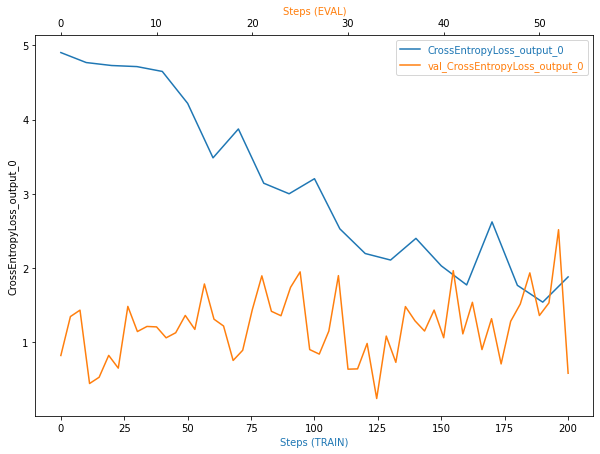

In [19]:
plot_tensor(trial, "CrossEntropyLoss_output_0") #Plotting the loss

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  

**There is anomalous behaviour of not getting smooth line.**

**Should adjust the pretrained model and fully connected network.**


In [16]:
# Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-440191285067/pytorch-training-2021-12-03-13-21-28-161/rule-output


In [17]:
! aws s3 ls {rule_output_path} --recursive

2021-12-03 13:27:48     335921 pytorch-training-2021-12-03-13-21-28-161/rule-output/ProfilerReport/profiler-output/profiler-report.html
2021-12-03 13:27:47     178312 pytorch-training-2021-12-03-13-21-28-161/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2021-12-03 13:27:43        191 pytorch-training-2021-12-03-13-21-28-161/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2021-12-03 13:27:43       6759 pytorch-training-2021-12-03-13-21-28-161/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2021-12-03 13:27:43        126 pytorch-training-2021-12-03-13-21-28-161/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2021-12-03 13:27:43        129 pytorch-training-2021-12-03-13-21-28-161/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2021-12-03 13:27:43       3343 pytorch-training-2021-12-03-13-21-28-161/rule-output/ProfilerReport/profiler-output/profiler-re

In [18]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-440191285067/pytorch-training-2021-12-03-13-21-28-161/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-440191285067/pytorch-training-2021-12-03-13-21-28-161/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-440191285067/pytorch-training-2021-12-03-13-21-28-161/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-440191285067/pytorch-training-2021-12-03-13-21-28-161/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-440191285067/pytorch-training

In [21]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [22]:
import IPython
# output the profiler report
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

**Module error raised in normal deplyed endpoints, so I had to use external inference script, and this script is credited to the next lesson.**

In [3]:
#model_location=estimator.model_data
#kerneldied frequently, had to manually input the model name
model_location= "s3://sagemaker-us-east-1-440191285067/pytorch-training-2021-12-03-13-21-28-161/output/model.tar.gz" 


In [4]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

In [5]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [13]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='endpoint.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor) 

In [14]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.g4dn.xlarge')

-------!

In [23]:
with open("./testdog.jpg", "rb") as f:
    payload = f.read()
    
type(payload)

bytes

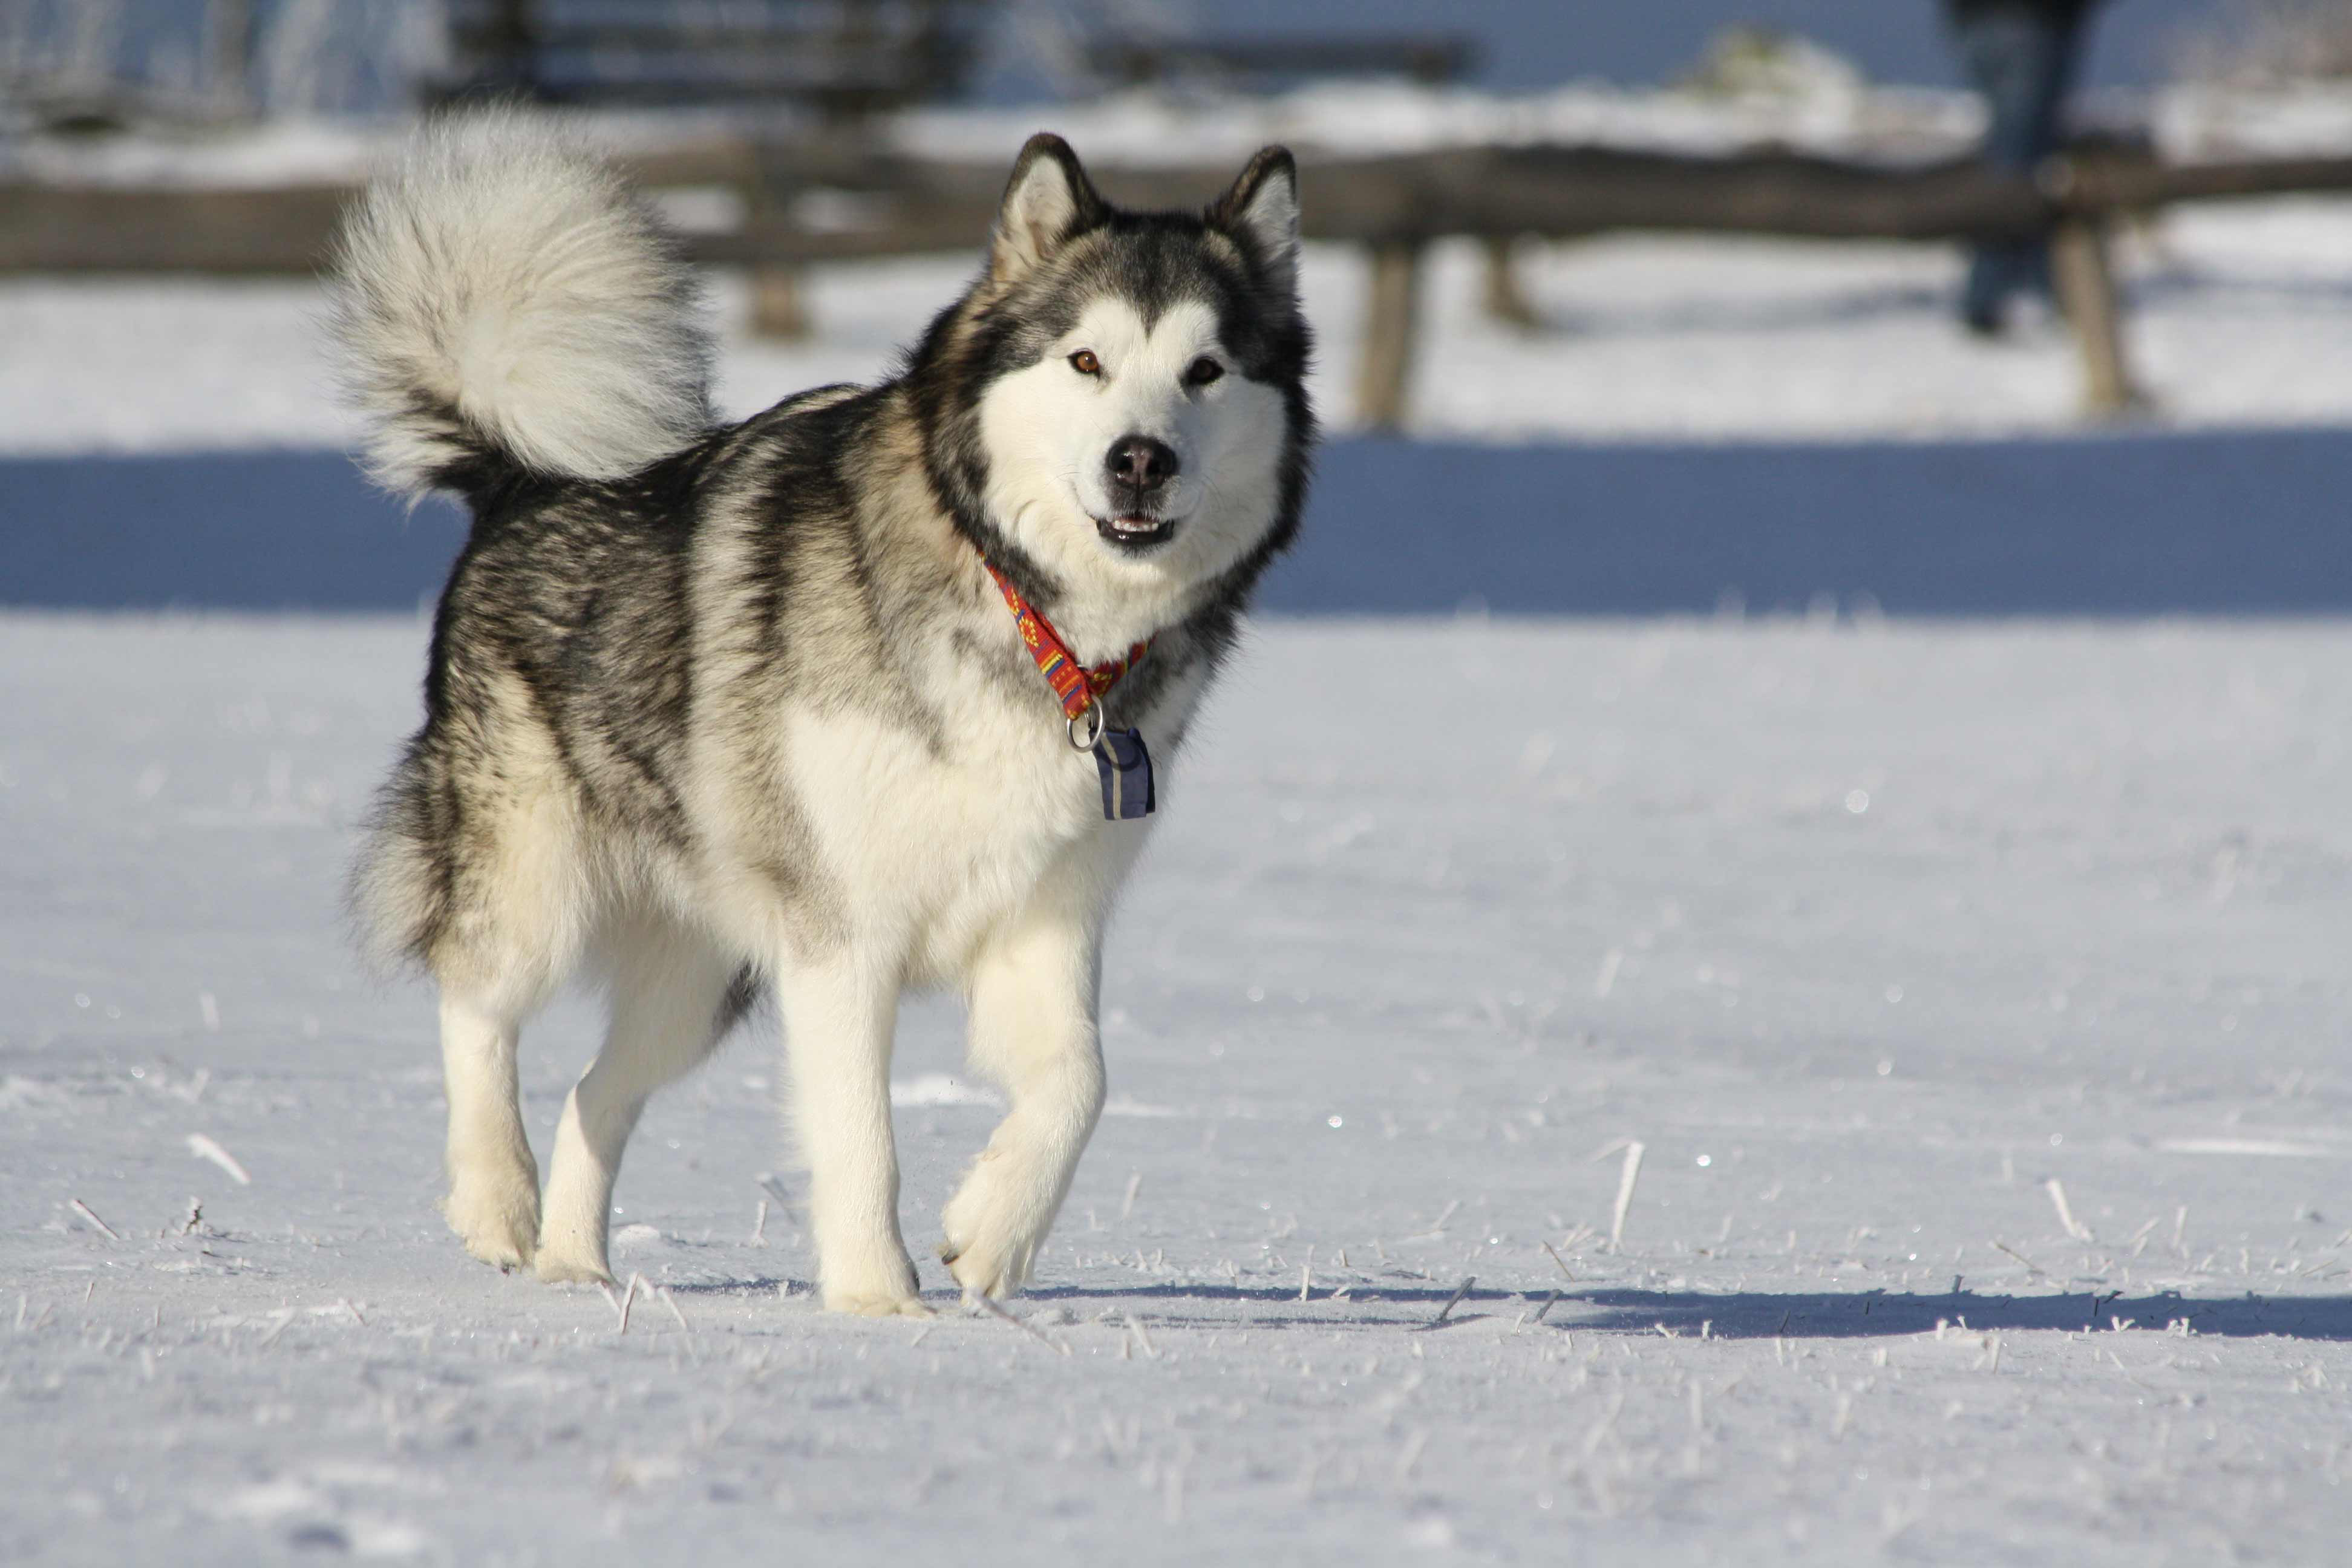

In [24]:
from PIL import Image
import io
Image.open(io.BytesIO(payload))

In [25]:
response=predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
response

[[-12.759783744812012,
  -6.354704856872559,
  -8.569709777832031,
  1.4409009218215942,
  7.5541276931762695,
  -0.9470134973526001,
  -9.467668533325195,
  -8.406106948852539,
  -13.968330383300781,
  -5.295602321624756,
  0.9109517931938171,
  -4.477198600769043,
  -8.594927787780762,
  -3.494572639465332,
  -14.223081588745117,
  -8.903887748718262,
  -10.499993324279785,
  -5.1771559715271,
  -3.14640736579895,
  -4.43063497543335,
  -2.5856196880340576,
  0.20533370971679688,
  -6.875555992126465,
  -7.982410430908203,
  -10.729002952575684,
  -10.878548622131348,
  -14.820954322814941,
  -6.981130599975586,
  -1.450259804725647,
  -10.012253761291504,
  -4.456787109375,
  -12.368659019470215,
  -9.152580261230469,
  -15.756423950195312,
  -12.984428405761719,
  -12.983675956726074,
  -13.826979637145996,
  -15.133891105651855,
  -3.922250747680664,
  -14.937938690185547,
  -15.383952140808105,
  -8.232112884521484,
  0.6636285185813904,
  -7.961689472198486,
  0.0828819647431373

In [26]:
import torch
import numpy as np
np.argmax(response, 1)

array([4])

which in turn out akita, but close.

In [27]:
# delete the endpoint once work is done as it charges overtime
predictor.delete_endpoint()